<a href="https://colab.research.google.com/github/zellning/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [ ]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests #RSS정보가져옴
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [3]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [ ]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [ ]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

In [9]:
set_seed(86) #42했더니 1로나와서 86으로바꾸니까 고양이 2마리로 인식
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [10]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [12]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'ls this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this is a picture of clothing. Specifically, it is a pair of boots designed for outdoor activities such as hiking or trekking. The materials and construction suggest that they are meant to provide durability and support in rugged terrain.
Yes, this appears to be a picture of clothing. The focus is on the garment worn by the individual, which seems to be part of a fashion shoot or advertisement. The style and presentation suggest that it could be from a designer collection or a catalog showcasing contemporary men's wear.
No, this image is not a picture of clothing. It is a photograph of an individual standing in front of a moss-covered wall. The focus is on the person and their attire rather than the clothing itself as a product for sale or display.
Yes, this appears to be a picture of clothing. The central focus is on the individual wearing a dark-colored hooded garment that resembles a hoodie or sweatshirt with a relaxed fit and pockets. The style suggests casual wear, possibly d

## 14-6 의류 판단 결과 시각화

In [13]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,False
3,,True
4,,True
5,,True
6,,False
7,,True
8,,True
9,,False


## 14-7 의류 이미지 필터링

In [14]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

In [15]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
3,,True
4,,True
5,,True
7,,True
8,,True
11,,True


## 14-8 의류 스타일 분석

In [16]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1482516394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [17]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the boots in the image suggests a classic and utilitarian design, often associated with outdoor activities such as hiking or mountaineering. The use of suede material indicates a preference for durable yet somewhat stylish footwear that can handle rugged conditions while maintaining an aesthetic appeal.\n\nThe color brown is versatile and commonly used in outdoor gear due to its ability to blend with natural environments like forests and mountains. This choice of color also adds to the timeless look of the boot, making it suitable for various seasons and occasions beyond just outdoor adventures.\n\nIn terms of trend changes, the boot's design appears to be quite traditional and does not show signs of following recent trends such as exaggerated high-heel designs or extreme minimalism seen in some contemporary fashion. Instead, it adheres to a more classic and functional approach, which has been a consistent trend in outdoor and adventure footwear over many years.\n\nOverall, this boot represents a practical and enduring style rather than one that follows the latest fashion fads, indicating a focus on functionality and durability over transient trends."
1,,True,"The style of the clothes in the image reflects a minimalist and modern aesthetic, which is characterized by simplicity, clean lines, and neutral colors. The black blazer is oversized, suggesting a trend towards more relaxed and comfortable fits that still maintain a formal appearance. This aligns with contemporary fashion trends where comfort meets sophistication.\n\nThe white top underneath adds to the minimalist look, providing a stark contrast against the dark blazer. White is often used in fashion as a versatile color that can signify purity, simplicity, and elegance. The choice of these two colors together—black and white—is timeless and suggests an understated confidence in personal style.\n\nThe overall outfit could be categorized under streetwear or smart casual wear, indicating a blend of practicality and style suitable for various settings. The absence of any visible logos or patterns further emphasizes the focus on silhouette and fit over branding, which is a common theme in modern fashion design."
3,,True,"The style of the clothes worn by the individual in the image can be described as minimalist and modern, with a focus on comfort and simplicity. The dark blue hooded garment appears to be made from a soft, possibly cotton or cotton-blend fabric, which suggests it is designed for casual wear rather than formal occasions. Hoodies have evolved over time, becoming a staple in contemporary fashion due to their versatility and comfort.\n\nIn terms of color, the choice of dark blue is a classic hue that tends to convey a sense of calmness and reliability. It's a timeless color that doesn't go out of style easily, making it a popular choice for everyday clothing. The lack of bold patterns or bright colors aligns with current trends favoring understated elegance and practicality.\n\nAs for trend changes, hoodies like the one pictured have seen a resurgence in popularity, partly due to their association with streetwear culture but also because they offer a relaxed fit that many find appealing. This garment has transcended its original sportswear roots to become part of mainstream fashion, often seen in high-end collections as well as casual settings.\n\nOverall, the clothing style depicted in the image reflects a blend of functionality, comfort, and a nod to contemporary fashion trends that prioritize simplicity and ease of use."
4,,True,"The style of the clothes in the image reflects a blend of classic and contemporary fashion elements. The black leather jacket is a timeless piece, often associated with biker culture and has been a staple in men's fashion for decades. It carries an edgy yet sophisticated vibe that can be both casual and stylish depending on how it is paired.\n\nUnderneath, the individual wears a striped 

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [ ]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model = 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

## 14-10 색상 정보 추출

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 12-11 06:24:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s, est. speed input: 1043.85 toks/s, output: 7.65 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, est. speed input: 492.56 toks/s, output: 36.04 toks/s]


**색상:**
- 검정색 (Black)
- 흰색 (White)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s, est. speed input: 1089.33 toks/s, output: 30.35 toks/s]


**색상:**
- 어두운 파란색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, est. speed input: 1016.08 toks/s, output: 29.69 toks/s]


- **검정색** (Black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, est. speed input: 1266.47 toks/s, output: 25.41 toks/s]


색상: 파란색, 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, est. speed input: 408.44 toks/s, output: 37.42 toks/s]


- 검은색 (Black)
- 갈색 (Brown)
- 보라색 (Purple)
- 녹색 (Olive Green)
- 파란색 (Navy Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, est. speed input: 707.76 toks/s, output: 30.53 toks/s]


**색상:**
- 베이지/라이트 탄


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s, est. speed input: 714.61 toks/s, output: 32.98 toks/s]

갈색 (brown)
검정색 (black)



/tmp/ipython-input-537633341.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [28]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it, est. speed input: 267.60 toks/s, output: 36.00 toks/s]


- **클래식**
- **실용적**
- **내구성**
- **자연친화적**
- **전통적**
- **기능성**



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, est. speed input: 180.36 toks/s, output: 40.73 toks/s]


- 미니멀리즘
- 현대적
- 단순함
- 깔끔한 선
- 중성색
- 루즈핏
- 편안함
- 세련됨
- 대조적
- 순수성
- 우아함
- 시간성
- 겸손한 자신감



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, est. speed input: 180.45 toks/s, output: 40.53 toks/s]


- **미니멀리즘**
- **현대적**
- **편안함**
- **단순함**
- **다크 블루**
- **소프트**
- **캐주얼**
- **타임리스**
- **무패턴**
- **실용성**
- **스트리트웨어**
- **메인스트림 패션**



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, est. speed input: 337.94 toks/s, output: 38.15 toks/s]


- 클래식
- 현대적
- 엣지 있는
- 세련된
- 믹스앤매치
- 스트리트웨어
- 스마트캐주얼
- eclectic 스타일링



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it, est. speed input: 253.10 toks/s, output: 39.52 toks/s]


- 캐주얼
- thoughtfully 구성된
- 편안함과 세련됨의 조화
- muted 색상 (파란색, 회색)
- 현대 캐주얼 Chic 스타일
- 편안함 중시
- 개인 표현
- 텍스처 레이어링



Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 161.85 toks/s, output: 40.46 toks/s]


- **따뜻함**
- **기능성**
- **다운 대체 소재**
- **내복**
- **어두운 색상**
- **다크 컬러**
- **클래식 패턴**
- **스트리트웨어**
- **밝은 색상 대비**
- **중립 색상**
- **텍스처**
- **층층이**
- **스포츠 요소**
- **실루엣 정의**
- **실용성**



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it, est. speed input: 179.07 toks/s, output: 40.41 toks/s]


- 클래식
- timeless
- 캐주얼
- 중성적
- 베이지/라이트 탄
- 다용도성
- 팝 컬러
- 대조적
- 단순성
- 우아함
- 빈티지 스타일
- 복고풍
- 현대적 기능성
- 역사적 미학



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it, est. speed input: 216.71 toks/s, output: 38.87 toks/s]

- 실용성과 패션의 조화
- 보온성 강조
- 아웃도어/도시 캐주얼 스타일
- 보호 기능과 스타일의 결합
- 럭셔리한 faux fur collar
- 윤리적 고려와 지속 가능성
- 레이어드 스타일



/tmp/ipython-input-3012919389.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [29]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the boots in the image suggests a classic and utilitarian design, often associated with outdoor activities such as hiking or mountaineering. The use of suede material indicates a preference for durable yet somewhat stylish footwear that can handle rugged conditions while maintaining an aesthetic appeal.\n\nThe color brown is versatile and commonly used in outdoor gear due to its ability to blend with natural environments like forests and mountains. This choice of color also adds to the timeless look of the boot, making it suitable for various seasons and occasions beyond just outdoor adventures.\n\nIn terms of trend changes, the boot's design appears to be quite traditional and does not show signs of following recent trends such as exaggerated high-heel designs or extreme minimalism seen in some contemporary fashion. Instead, it adheres to a more classic and functional approach, which has been a consistent trend in outdoor and adventure footwear over many years.\n\nOverall, this boot represents a practical and enduring style rather than one that follows the latest fashion fads, indicating a focus on functionality and durability over transient trends.",갈색,- **클래식**\n- **실용적**\n- **내구성**\n- **자연친화적**\n- **전통적**\n- **기능성**
1,,True,"The style of the clothes in the image reflects a minimalist and modern aesthetic, which is characterized by simplicity, clean lines, and neutral colors. The black blazer is oversized, suggesting a trend towards more relaxed and comfortable fits that still maintain a formal appearance. This aligns with contemporary fashion trends where comfort meets sophistication.\n\nThe white top underneath adds to the minimalist look, providing a stark contrast against the dark blazer. White is often used in fashion as a versatile color that can signify purity, simplicity, and elegance. The choice of these two colors together—black and white—is timeless and suggests an understated confidence in personal style.\n\nThe overall outfit could be categorized under streetwear or smart casual wear, indicating a blend of practicality and style suitable for various settings. The absence of any visible logos or patterns further emphasizes the focus on silhouette and fit over branding, which is a common theme in modern fashion design.",색상\n 검정색 black\n 흰색 white,- 미니멀리즘\n- 현대적\n- 단순함\n- 깔끔한 선\n- 중성색\n- 루즈핏\n- 편안함\n- 세련됨\n- 대조적\n- 순수성\n- 우아함\n- 시간성\n- 겸손한 자신감
3,,True,"The style of the clothes worn by the individual in the image can be described as minimalist and modern, with a focus on comfort and simplicity. The dark blue hooded garment appears to be made from a soft, possibly cotton or cotton-blend fabric, which suggests it is designed for casual wear rather than formal occasions. Hoodies have evolved over time, becoming a staple in contemporary fashion due to their versatility and comfort.\n\nIn terms of color, the choice of dark blue is a classic hue that tends to convey a sense of calmness and reliability. It's a timeless color that doesn't go out of style easily, making it a popular choice for everyday clothing. The lack of bold patterns or bright colors aligns with current trends favoring understated elegance and practicality.\n\nAs for trend changes, hoodies like the one pictured have seen a resurgence in popularity, partly due to their association with streetwear culture but also because they offer a relaxed fit that many find appealing. This garment has transcended its original sportswear roots to become part of mainstream fashion, often seen in high-end collections as well as casual settings.\n\nOverall, the clothing style depicted in the image reflects a blend of functionality, comfort, and a nod to contemporary fashion trends that prioritize simplicity and ease of use.",색상\n 어두운 파란색,- **미니멀리즘**\n- **현대적**\n- **편안함**\n- **단순함**\n- **다크 블루**\n- **소프트**\n- **캐주얼**\n- **타임리스**\n- **무패턴**\n- **실용성**\n- **스트리트웨어**\n- **메인스트림 패션**
4,,True,"The style of the clothes 

## 14-12 텍스트 데이터 정제

In [30]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

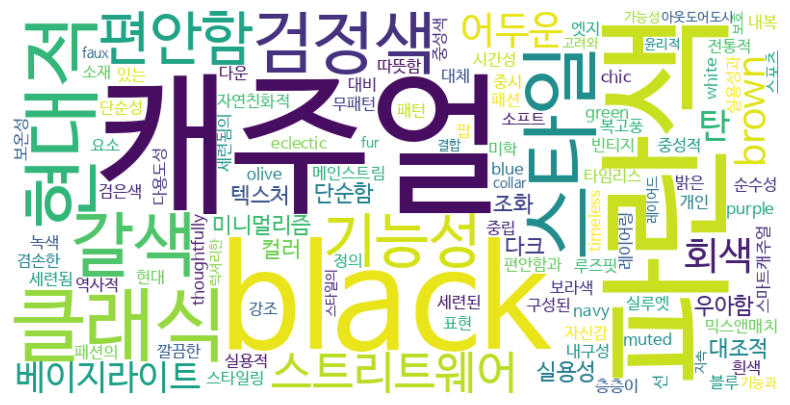

In [31]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [32]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스ㅏ일 노트 : {row.style}\n이미지 url:{row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서형식은 markdown으로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text


Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.12s/it, est. speed input: 128.42 toks/s, output: 39.46 toks/s]


In [33]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 다양한 해외 패션 룩북에서 관찰되는 주요 트렌드를 분석하고, 이를 통해 미래 패션 경향의 방향성을 제시합니다. 주요 분석 대상은 다양한 계절과 활동에 적합한 의류 및 신발 스타일로 구성되어 있습니다.

## 트렌드 분석

### 1. **실용성과 스타일의 융합**
- **아웃도어 및 캐주얼 웨어**: 
  - **스타일**: 클래식한 디자인과 현대적인 기능성을 결합한 부츠와 후드티가 주를 이루고 있다. 예를 들어, 갈색 suede 부츠와 검은색 후드티는 실용성과 스타일을 동시에 제공한다.
  - **특징**: 기능성 소재와 내구성을 유지하면서도 트렌디한 색상과 패턴을 활용하여 다양한 계절에 걸쳐 착용 가능하다.
  
- **겨울 의류**:
  - **스타일**: 보온성이 뛰어난 패딩 재킷과 다양한 색상 조합의 코트가 주목받고 있다. 예를 들어, 검은색 패딩 재킷과 플라이나 다크 블루 코트의 조합은 따뜻함과 세련됨을 동시에 제공한다.
  - **특징**: 어두운 색상과 패턴의 혼합은 클래식한 감각을 유지하면서도 현대적인 감각을 더한다. 또한, 레이어링 기법은 계절 변화에 유연하게 대응할 수 있는 실용성을 강조한다.

### 2. **지속 가능성과 윤리적 패션**
- **친환경 소재 활용**:
  - **스타일**: faux fur 소재를 활용한 코트와 재킷이 주목받고 있다. 예를 들어, 동물성 소재 대신 사용되는 faux fur는 윤리적 소비 트렌드와 잘 어울린다.
  - **특징**: 이러한 소재 선택은 환경 친화적이고 동물 복지에 대한 관심을 반영하며, 패션 산업의 지속 가능성에 대한 요구를 충족시킨다.

### 3. **현대적이고 eclectic한 스타일링**
- **믹스 앤 매치**:
  - **스타일**: 다양한 패턴과 텍스처를 혼합한 의류 조합이 인기다. 예를 들어, 가죽 재킷과 스트라이프 셔츠, 또는 다양한 색상의 패딩 재킷과 레이어링 아이템의 조합이 대표적이다.
  - **특징**: 이러한 접근법은 개인의 독특한 스타일을 표현하며, 현대 패션에서의 개성 표현과 실용성의 균형을 보여준다.

### 4. **기능성과 패션의 융합**
- **기능성 소재와 디자인**:
  - **스타일**: 편안함과 기능성을 동시에 추구하는 디자인이 두드러진다. 예를 들어, 패딩 재킷과 다양한 색상의 스니커즈는 일상적인 활동과 스타일리시한 룩을 동시에 제공한다.
  - **특징**: 이러한 제품들은 사용자의 활동성을 높이면서도 패션적인 감각을 유지하여 실용성과 스타일의 조화를 강조한다.

## 결론
해외 패션 룩북에서 관찰되는 주요 트렌드는 실용성과 스타일의 융합, 지속 가능성과 윤리적 패션의 중요성, 그리고 현대적이고 eclectic한 스타일링의 인기를 중심으로 요약될 수 있다. 이러한 경향은 미래 패션 산업이 개인의 활동성과 환경 친화성, 그리고 독특한 개인 표현을 동시에 추구하는 방향으로 나아갈 것임을 시사한다. 이러한 트렌드는 소비자들이 더 나은 생활 품질과 윤리적 가치를 추구하면서 동시에 패션을 통해 자신만의 스타일을 표현하는 데 중점을 둘 것으로 예상된다.

---

이 보고서는 다양한 패션 요소와 그들의 상호작용을 통해 미래 패션 트렌드의 방향성을 분석하고 제시하였습니다.